In [ ]:
import torch
from core.networks.embeddUnet import ConditionalUnet1D
from core.diffusion.diffusion import PlaneDiffusionPolicy, build_networks_from_config, build_noise_scheduler_from_config
from core.datasets import plane_dataset_embeed
from config.plane_test_embeed import PlaneTestEmbedConfig
import matplotlib.pyplot as plt
import numpy as np

import io
from pathlib import Path
from typing import Union
from utils.dataset_utils import sample_start_goal, random_rectangles, rectangles_to_grid

import imageio.v3 as iio   

In [ ]:

def create_test_scenario(bounds, cell_size, origin, rng, max_rectangles, device='cuda', batch_size=1):
    """Create a test scenario with a 3x2 rectangular obstacle in the center of an 8x8 grid"""
    nx, ny = (
    int((hi - lo) / cell_size) for lo, hi in bounds
)

    rects = random_rectangles(
        bounds=bounds,
        grid=grid,
        cell_size=cell_size,
        origin=origin,
        rng=rng,
        max_rectangles=max_rectangles,
    )
    
    grid = rectangles_to_grid(
        nx=nx,
        ny=ny,
        bounds=bounds,
        cell_size=cell_size,
        rects=rects,
    )
    
    
    start, goal = sample_start_goal(
        bounds=bounds,
        grid=grid,
        cell_size=cell_size,
        origin=origin,
        rng=rng,
    )
    

    return start, goal, grid

def generate_path(policy: PlaneDiffusionPolicy, start, goal, obstacles):
    device = start.device
    obs_dim = start.shape[1]
    pred_horizon = policy.config["horizon"]

    # Fake observation sample (all zeros)
    fake_obs_sample = np.zeros((pred_horizon, obs_dim), dtype=np.float32)


    start_np = start.cpu().numpy()[0]
    goal_np = goal.cpu().numpy()[0]
    env_cond = np.concatenate([start_np, goal_np])  # [2 * obs_dim]


    map_cond = obstacles[0].cpu().numpy()  # shape: [1, 8, 8]


    obs_dict = {
        "sample": fake_obs_sample,
        "env": env_cond,
        "map": map_cond,
    }


    trajectory, trajectory_all = policy.predict_action(obs_dict)  # shape: [pred_horizon, obs_dim]

    return torch.tensor(trajectory, device=device).unsqueeze(0), trajectory_all  # [1, H, obs_dim]

import matplotlib.pyplot as plt
import numpy as np

def visualize_result(trajectory, start, goal, obstacles, save_path=None):
    """Visualize the generated trajectory with obstacle map overlay"""
    # Convert to numpy
    traj_np = trajectory[0].cpu().numpy()
    start_np = start[0].cpu().numpy()
    goal_np = goal[0].cpu().numpy()
    obs_np = obstacles[0, 0].cpu().numpy()  # shape: [8, 8]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Trajectory with obstacles
    ax1.imshow(obs_np, origin='lower', cmap='gray_r', extent=[0, 8, 0, 8], alpha=0.5)  # transpose to match axis

    # ax1.plot(traj_np[:, 0], traj_np[:, 1], 'b-', linewidth=2, label='Generated Path')
    # ax1.plot(traj_np[:, 0], traj_np[:, 1], 'bo', markersize=3, alpha=0.6)
    ax1.plot(start_np[0], start_np[1], 'go', markersize=10, label='Start')
    ax1.plot(goal_np[0], goal_np[1], 'ro', markersize=10, label='Goal')
    ax1.set_xlim(0, 8)
    ax1.set_ylim(0, 8)
    ax1.set_title('Generated Trajectory')
    ax1.set_xticks(np.arange(0, 9))
    ax1.set_yticks(np.arange(0, 9))
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Trajectory over time
    # ax2.plot(range(len(traj_np)), traj_np[:, 0], 'r-', label='X coordinate')
    # ax2.plot(range(len(traj_np)), traj_np[:, 1], 'b-', label='Y coordinate')
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Position')
    ax2.set_title('Trajectory Components')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()


In [7]:
def visualize_trajectory_gif(
    action_history: Union[np.ndarray, torch.Tensor],
    start: Union[np.ndarray, torch.Tensor],
    goal: Union[np.ndarray, torch.Tensor],
    obstacles: Union[np.ndarray, torch.Tensor],
    save_path: str = "trajectory_evolution.gif",
    fps: int = 5,
):

    action_history = (
        action_history.detach().cpu().numpy()
        if isinstance(action_history, torch.Tensor)
        else np.asarray(action_history)
    )
    start = start.detach().cpu().numpy() if isinstance(start, torch.Tensor) else np.asarray(start)
    goal = goal.detach().cpu().numpy() if isinstance(goal, torch.Tensor) else np.asarray(goal)
    obstacles = (
        obstacles.detach().cpu().numpy() if isinstance(obstacles, torch.Tensor) else np.asarray(obstacles)
    )

    start = start.squeeze()
    goal = goal.squeeze()
    if obstacles.ndim == 4:                      # [B, C, H, W]
        obstacles = obstacles[0, 0]
    elif obstacles.ndim == 3:                    # [C, H, W]
        obstacles = obstacles[0]

    Path(save_path).parent.mkdir(parents=True, exist_ok=True)

    frames = []
    for step_idx, traj in enumerate(action_history):
        fig, ax = plt.subplots(figsize=(5, 5))

        ax.imshow(
            obstacles,
            cmap="gray_r",
            origin="lower",
            extent=[0, obstacles.shape[1], 0, obstacles.shape[0]],
            alpha=0.25,
        )


        ax.plot(traj[:, 0], traj[:, 1], "b-", linewidth=2, label="Path")
        ax.scatter(traj[:, 0], traj[:, 1], c="blue", s=12, alpha=0.7)


        ax.scatter(start[0], start[1], c="green", s=80, marker="o", label="Start")
        ax.scatter(goal[0], goal[1], c="red", s=80, marker="o", label="Goal")


        ax.set_xlim(0, obstacles.shape[1])
        ax.set_ylim(0, obstacles.shape[0])
        ax.set_title(f"Diffusion step {step_idx}/{len(action_history) - 1}")
        ax.grid(True, alpha=0.3)
        ax.legend(loc="upper right", fontsize="small")


        buf = io.BytesIO()
        plt.savefig(buf, format="png", dpi=120, bbox_inches="tight")
        plt.close(fig)
        buf.seek(0)
        frames.append(iio.imread(buf))  


    iio.imwrite(save_path, frames, duration=1 / fps)  
    print(f"GIF Save to: {Path(save_path).resolve()}")

Input sample shape: torch.Size([1, 32, 2])
Time embed shape: torch.Size([1, 256]), Map cond embed shape: torch.Size([1, 32]), Env cond embed shape: torch.Size([1, 64])
Input sample shape: torch.Size([1, 32, 2])
Time embed shape: torch.Size([1, 256]), Map cond embed shape: torch.Size([1, 32]), Env cond embed shape: torch.Size([1, 64])
Input sample shape: torch.Size([1, 32, 2])
Time embed shape: torch.Size([1, 256]), Map cond embed shape: torch.Size([1, 32]), Env cond embed shape: torch.Size([1, 64])
Input sample shape: torch.Size([1, 32, 2])
Time embed shape: torch.Size([1, 256]), Map cond embed shape: torch.Size([1, 32]), Env cond embed shape: torch.Size([1, 64])
Input sample shape: torch.Size([1, 32, 2])
Time embed shape: torch.Size([1, 256]), Map cond embed shape: torch.Size([1, 32]), Env cond embed shape: torch.Size([1, 64])
Input sample shape: torch.Size([1, 32, 2])
Time embed shape: torch.Size([1, 256]), Map cond embed shape: torch.Size([1, 32]), Env cond embed shape: torch.Size([

/var/folders/p3/v0zvzgdj3b96bkk4w12c23w80000gn/T/ipykernel_56923/3926491101.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


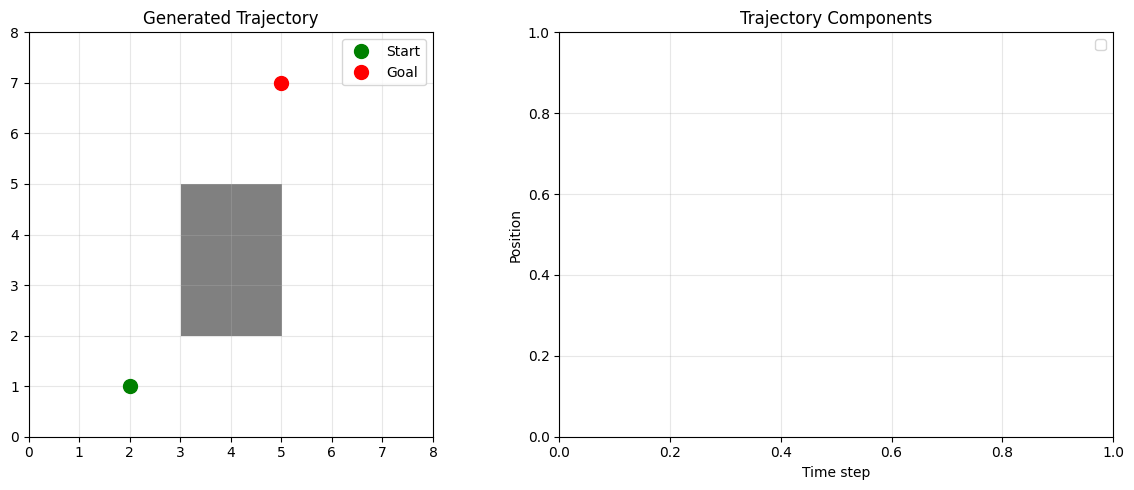

In [8]:
ckpt_path = '/Users/yulinli/Desktop/Exp/diffusion_policy/ckpt_final.ckpt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


config = PlaneTestEmbedConfig()
config_dict = config.to_dict()
net = ConditionalUnet1D(
    input_dim=config.network_config["unet_config"]["action_dim"],
    global_cond_dim=config.network_config["vit_config"]["num_classes"] + config.network_config["mlp_config"]["embed_dim"],
    network_config=config.network_config
)
scheduler = build_noise_scheduler_from_config(config_dict)

policy = PlaneDiffusionPolicy(model=net, noise_scheduler=scheduler, config=config_dict, device=device)
policy.load_weights(ckpt_path)


start, goal, obstacles = create_test_scenario(device=device)


trajectory, trajectory_all = generate_path(policy, start, goal, obstacles)


# visualize_trajectory_gif(trajectory_all, start, goal, obstacles, save_path="trajectory_evolution_obstacle.gif", fps=10)
visualize_result(trajectory, start, goal, obstacles, save_path="trajectory_obstacle_no_path.png")